# Introduction

This notebook analyses...

## Core aspects

- cohorts: defined by month of creation of first cash advance (`created_at`)

goal:

- track monthly evolution of key metrics by cohort

key metrics:

- frequency of usage of cash advancements over time
- incident rate
- revenue generated
- new relevant metric (TBD)

## Exploratory Data Analysis (EDA)
1. conduct an exploratory data analysis to gain a comprehensive understanding of the dataset.

2. Explore key statistics, distributions, and visualizations to identify patterns and outliers.

## Data Quality Analysis
1. Assess the quality of the dataset by identifying missing values, data inconsistencies, and potential errors.

2. Implement data cleaning and preprocessing steps to ensure the reliability of your analysis. 


## Calculate and analyze the following metrics for each cohort:

1. Frequency of Service Usage: Understand how often users from each cohort utilize IronHack Payments' cash advance services over time.

2. Incident Rate: Determine the incident rate, specifically focusing on payment incidents, for each cohort. Identify if there are variations in incident rates among different cohorts.

3. Revenue Generated by the Cohort: Calculate the total revenue generated by each cohort over months to assess the financial impact of user behavior.

4. New Relevant Metric: Propose and calculate a new relevant metric that provides additional insights into user behavior or the performance of IronHack Payments' services.

relevant columns:

cashRequest:
  - `created_at`
  - `updated_at`

## Deliverables
1. Python Code: Provide well-documented Python code that conducts the cohort analysis, including data loading, preprocessing, cohort creation, metric calculation, and visualization.

## Setup requirements

- extract/define cohorts in dataset

## Table of contents

1. [Introduction](#introduction)
2. [EDA](#eda)  
    a. [Data overview](#data-overview)  
    b. [Data cleaning/quality analysis](#data-cleaning/quality-analysis)  
    c. [Further EDA](#further-eda)
3. [Target data analysis](#target-data-analysis)

# EDA

## Preamble

Loading libraries

In [295]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [296]:
# Set the Seaborn context to "poster" for larger text and figures
sns.set_context("poster")

# Set the default figure size for Seaborn plots
sns.set(rc={"figure.figsize": (12., 6.)})

# Set the Seaborn style to "whitegrid" for a white background with gridlines
sns.set_style("whitegrid")

Import data

In [297]:
#First we removed the spaces from the csv files so we can easuly import them here

# We modified our import process to directly cast proper datatypes for dates.
# Float/integer will still be handled in data cleaning, 
# since some of the offending columns have NaN values causing issues (hence presumably the wrong automatic casting)


# lists of columns containing dates

datetime_columns_cash_request = [
    "created_at",
    "updated_at",
    "moderated_at",
    "cash_request_received_date",
    "reimbursement_date",
    "money_back_date",
    "send_at",
    "reco_last_update",
    "reco_creation"
]
   
datetime_columns_fees = [
    "created_at",
    "updated_at",
    "paid_at",
    "from_date",
    "to_date"
]


fees = pd.read_csv("../project_dataset/extract-fees-dataanalyst.csv",
                            parse_dates = datetime_columns_fees)
cashRequest = pd.read_csv("../project_dataset/extract-cashrequest-dataanalyst.csv", 
                            parse_dates = datetime_columns_cash_request)



In [298]:
# This is how we get a small insight in the data
display(fees.head())

,id,cash_request_id,type,status,category,total_amount,reason,created_at,updated_at,paid_at,from_date,to_date,charge_moment
0,6537,14941.0,instant_payment,rejected,NaN,5.0,Instant Payment Cash Request 14941,2020-09-07 10:47:27.423150+00:00,2020-10-13 14:25:09.396112+00:00,2020-12-17 14:50:07.47011+00,NaN,NaN,after
1,6961,11714.0,incident,accepted,rejected_direct_debit,5.0,rejected direct debit,2020-09-09 20:51:17.998653+00:00,2020-10-13 14:25:15.537063+00:00,2020-12-08 17:13:10.45908+00,NaN,NaN,after
2,16296,23371.0,instant_payment,accepted,NaN,5.0,Instant Payment Cash Request 23371,2020-10-23 10:10:58.352972+00:00,2020-10-23 10:10:58.352994+00:00,2020-11-04 19:34:37.43291+00,NaN,NaN,after
3,20775,26772.0,instant_payment,accepted,NaN,5.0,Instant Payment Cash Request 26772,2020-10-31 15:46:53.643958+00:00,2020-10-31 15:46:53.643982+00:00,2020-11-19 05:09:22.500223+00,NaN,NaN,after
4,11242,19350.0,instant_payment,accepted,NaN,5.0,Instant Payment Cash Request 19350,2020-10-06 08:20:17.170432+00:00,2020-10-13 14:25:03.267983+00:00,2020-11-02 14:45:20.355598+00,NaN,NaN,after


In [299]:
# Overview of data in fees
fees.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21061 entries, 0 to 21060
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   id               21061 non-null  int64              
 1   cash_request_id  21057 non-null  float64            
 2   type             21061 non-null  object             
 3   status           21061 non-null  object             
 4   category         2196 non-null   object             
 5   total_amount     21061 non-null  float64            
 6   reason           21061 non-null  object             
 7   created_at       21061 non-null  datetime64[ns, UTC]
 8   updated_at       21061 non-null  datetime64[ns, UTC]
 9   paid_at          15531 non-null  object             
 10  from_date        7766 non-null   object             
 11  to_date          7766 non-null   object             
 12  charge_moment    21061 non-null  object             
dtypes: datetime64[ns

**Observations**:

- `cash_request_id` is automatically cast as float64. `int` might be more plausible, change in cleaning
- date-related columns (`created_at`,`updated__at`,`paid_at`,`from_date`,`to_date`) will need special treatment 

- after date casting at import still trouble for `paid_at`,`from_date`,`to_date`

In [300]:
display(cashRequest.head())

,id,amount,status,created_at,updated_at,user_id,moderated_at,deleted_account_id,reimbursement_date,cash_request_received_date,money_back_date,transfer_type,send_at,recovery_status,reco_creation,reco_last_update
0,5,100.0,rejected,2019-12-10 19:05:21.596873+00:00,2019-12-11 16:47:42.407830+00:00,804.0,2019-12-11 16:47:42.405646+00,NaN,2020-01-09 19:05:21.596363+00,NaT,NaN,regular,NaN,NaN,NaT,NaT
1,70,100.0,rejected,2019-12-10 19:50:12.347780+00:00,2019-12-11 14:24:22.900054+00:00,231.0,2019-12-11 14:24:22.897988+00,NaN,2020-01-09 19:50:12.34778+00,NaT,NaN,regular,NaN,NaN,NaT,NaT
2,7,100.0,rejected,2019-12-10 19:13:35.825460+00:00,2019-12-11 09:46:59.779773+00:00,191.0,2019-12-11 09:46:59.777728+00,NaN,2020-01-09 19:13:35.825041+00,NaT,NaN,regular,NaN,NaN,NaT,NaT
3,10,99.0,rejected,2019-12-10 19:16:10.880172+00:00,2019-12-18 14:26:18.136163+00:00,761.0,2019-12-18 14:26:18.128407+00,NaN,2020-01-09 19:16:10.879606+00,NaT,NaN,regular,NaN,NaN,NaT,NaT
4,1594,100.0,rejected,2020-05-06 09:59:38.877376+00:00,2020-05-07 09:21:55.340080+00:00,7686.0,2020-05-07 09:21:55.320193+00,NaN,2020-06-05 22:00:00+00,NaT,NaN,regular,NaN,NaN,NaT,NaT


In [301]:
# Overview of data in cashRequest
cashRequest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23970 entries, 0 to 23969
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   id                          23970 non-null  int64              
 1   amount                      23970 non-null  float64            
 2   status                      23970 non-null  object             
 3   created_at                  23970 non-null  datetime64[ns, UTC]
 4   updated_at                  23970 non-null  datetime64[ns, UTC]
 5   user_id                     21867 non-null  float64            
 6   moderated_at                16035 non-null  object             
 7   deleted_account_id          2104 non-null   float64            
 8   reimbursement_date          23970 non-null  object             
 9   cash_request_received_date  16289 non-null  datetime64[ns]     
 10  money_back_date             16543 non-null  object        

**Observations**:

- `delete_account_id` and `user_id` needn't be floats (cast to int later)
- date-related columns (`created_at`,`updated__at`,`moderated_at`...) will need special treatment
- fewer unique `user_id` values than cashRequest `id`s: indicating multiple transactions for some users or actual missing values?


- after date casting at import the following fields are still `object` rather than `datetime`:
  `moderated_at`,`reimbursement_date`,`money_back_date`,`send_at`

In [302]:
# functions
def evaluateDataFrame(df):
    # Lets check how many values we actually have
    print("Total amount of records")
    print(len(df))
    print()
    # This shows us the amount of empty rows for each column 
    print("Empty rows")
    print(df.isnull().sum())
    print()
    # check the number of unique values for each column 
    print("Unique rows")
    print(df.nunique())
    print()
    #print("DataFrame info")            # we're already calling this earlier, might make sense for plain-py version (although then we could put info() at start and remove len, since that's also displayed by info())
    #fees.info()
    #print()
    

def inspect_data_types(df, name="DataFrame"):
    print(f"=== {name} ===")
    numerical = df.select_dtypes(include='number').columns.tolist()
    categorical = df.select_dtypes(include='object').columns.tolist()
    datetime = df.select_dtypes(include=['datetime','datetime64','datetime64[ns, UTC]']).columns.tolist()
      
    print(f"Numerical columns ({len(numerical)}): {numerical}")
    print(f"Categorical columns ({len(categorical)}): {categorical}")
    print(f"Date columns ({len(datetime)}): {datetime}")
    print()
    
    return numerical, categorical, datetime         # modified to also return the lists for further use




In [303]:
# calling functions
# commented for now, piecewise presentation might be more readable in notebook 

# evaluateDataFrame(cashRequest)
# evaluateDataFrame(fees)

# inspect_data_types(cashRequest)
# inspect_data_types(fees)

In [304]:
cashRequest.isna().sum()


id                                0
amount                            0
status                            0
created_at                        0
updated_at                        0
user_id                        2103
moderated_at                   7935
deleted_account_id            21866
reimbursement_date                0
cash_request_received_date     7681
money_back_date                7427
transfer_type                     0
send_at                        7329
recovery_status               20640
reco_creation                 20640
reco_last_update              20640
dtype: int64

In [305]:
cashRequest.nunique()


id                            23970
amount                           41
status                            7
created_at                    23970
updated_at                    23970
user_id                       10798
moderated_at                  16035
deleted_account_id             1141
reimbursement_date             4089
cash_request_received_date      312
money_back_date               12221
transfer_type                     2
send_at                       16641
recovery_status                   4
reco_creation                  3330
reco_last_update               3330
dtype: int64

In [306]:
fees.isna().sum()

id                     0
cash_request_id        4
type                   0
status                 0
category           18865
total_amount           0
reason                 0
created_at             0
updated_at             0
paid_at             5530
from_date          13295
to_date            13295
charge_moment          0
dtype: int64

In [307]:
fees.nunique()

id                 21061
cash_request_id    12933
type                   3
status                 4
category               2
total_amount           2
reason             15149
created_at         21026
updated_at         21061
paid_at            15529
from_date           1084
to_date             1560
charge_moment          2
dtype: int64

In [308]:
fees['total_amount'].unique()

array([ 5., 10.])

In [309]:
fees[['category','total_amount']]

,category,total_amount
0,NaN,5.0
1,rejected_direct_debit,5.0
2,NaN,5.0
3,NaN,5.0
4,NaN,5.0
...,...,...
21056,NaN,5.0
21057,NaN,5.0
21058,NaN,5.0
21059,NaN,5.0


Only two types of fees are levied: 5 and 10 Euros(?) - maybe convert to int as well?

In [310]:

cashr_numcols, cashr_strcols, cashr_dtcols = inspect_data_types(cashRequest, name="cashRequest")


=== cashRequest ===
Numerical columns (4): ['id', 'amount', 'user_id', 'deleted_account_id']
Categorical columns (7): ['status', 'moderated_at', 'reimbursement_date', 'money_back_date', 'transfer_type', 'send_at', 'recovery_status']
Date columns (5): ['created_at', 'updated_at', 'cash_request_received_date', 'reco_creation', 'reco_last_update']



In [311]:
fees_numcols, fees_strcols, fees_dtcols = inspect_data_types(fees, name="fees")


=== fees ===
Numerical columns (3): ['id', 'cash_request_id', 'total_amount']
Categorical columns (8): ['type', 'status', 'category', 'reason', 'paid_at', 'from_date', 'to_date', 'charge_moment']
Date columns (2): ['created_at', 'updated_at']



Several of the date fields aren't typed correctly, fix in data cleaning and rerun function

**Observations**

- 2103 empty values in `cashRequest.user_id` corresponding to the difference to `id` noted above
  - also: very close to value of `deleted_account` id (2104), so possible relation to that
- fees are associated to cashRequests via `cash_request_id`

We used these insights to adapt our data import in order to directly cast the correct datatypes for columns that were not correctly identified automatically.  

## Data cleaning/quality analysis

### Instructions after EDA
1. Parse all values to the right data types
2. remove loose items (like fees without cashRequest)
3. 

In [312]:
# clean the start and ends of all column names so we get no suprises in the data retrieval later
fees.columns = fees.columns.str.strip()
cashRequest.columns = cashRequest.columns.str.strip()

The next block is going to fix datatypes for both dataframes, i.e. fixing the missing dates and casting some columns as integers.

In [313]:

# This is antoher option of parsing datatypes
# errors="coerce" -> means that erroes will force conversion and replace any invalid or unconvertible values with NaT
datetime_columns_cash_request = [
    "created_at",
    "updated_at",
    "moderated_at",
    "cash_request_received_date",
    "reimbursement_date",
    "money_back_date",
    "send_at",
    "reco_last_update",
    "reco_creation"
]

for col in datetime_columns_cash_request:
    cashRequest[col] = pd.to_datetime(cashRequest[col], errors="coerce")
    
# the cash_request_received_date doesnt have an timezone so we normalize it to the standard utc
cashRequest["cash_request_received_date"] = cashRequest["cash_request_received_date"].dt.tz_localize("UTC")
datetime_columns_fees = [
    "created_at",
    "updated_at",
    "paid_at",
    "from_date",
    "to_date"
]

for col in datetime_columns_fees:
    fees[col] = pd.to_datetime(fees[col], errors="coerce")
    


float_to_int_fees = [
    "cash_request_id",
    "id"
]

# This currently doesn't work with astype(int), while astype("Int64")
for col in float_to_int_fees:
    fees[col] = pd.to_numeric(fees[col], errors="coerce").astype("Int64")
     
float_to_int_cash_request = [
    "user_id",
    "deleted_account_id",
    "id"
]

for col in float_to_int_cash_request:
    cashRequest[col] = pd.to_numeric(cashRequest[col], errors="coerce").astype("Int64")
    
fees.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21061 entries, 0 to 21060
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   id               21061 non-null  Int64              
 1   cash_request_id  21057 non-null  Int64              
 2   type             21061 non-null  object             
 3   status           21061 non-null  object             
 4   category         2196 non-null   object             
 5   total_amount     21061 non-null  float64            
 6   reason           21061 non-null  object             
 7   created_at       21061 non-null  datetime64[ns, UTC]
 8   updated_at       21061 non-null  datetime64[ns, UTC]
 9   paid_at          15438 non-null  datetime64[ns, UTC]
 10  from_date        6749 non-null   datetime64[ns, UTC]
 11  to_date          6512 non-null   datetime64[ns, UTC]
 12  charge_moment    21061 non-null  object             
dtypes: Int64(2), dat

In [314]:
cashRequest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23970 entries, 0 to 23969
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   id                          23970 non-null  Int64              
 1   amount                      23970 non-null  float64            
 2   status                      23970 non-null  object             
 3   created_at                  23970 non-null  datetime64[ns, UTC]
 4   updated_at                  23970 non-null  datetime64[ns, UTC]
 5   user_id                     21867 non-null  Int64              
 6   moderated_at                15912 non-null  datetime64[ns, UTC]
 7   deleted_account_id          2104 non-null   Int64              
 8   reimbursement_date          3050 non-null   datetime64[ns, UTC]
 9   cash_request_received_date  16289 non-null  datetime64[ns, UTC]
 10  money_back_date             12040 non-null  datetime64[ns,

In [315]:

cashr_numcols, cashr_strcols, cashr_dtcols = inspect_data_types(cashRequest, name="cashRequest")

=== cashRequest ===
Numerical columns (4): ['id', 'amount', 'user_id', 'deleted_account_id']
Categorical columns (3): ['status', 'transfer_type', 'recovery_status']
Date columns (9): ['created_at', 'updated_at', 'moderated_at', 'reimbursement_date', 'cash_request_received_date', 'money_back_date', 'send_at', 'reco_creation', 'reco_last_update']



In [316]:
fees.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21061 entries, 0 to 21060
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   id               21061 non-null  Int64              
 1   cash_request_id  21057 non-null  Int64              
 2   type             21061 non-null  object             
 3   status           21061 non-null  object             
 4   category         2196 non-null   object             
 5   total_amount     21061 non-null  float64            
 6   reason           21061 non-null  object             
 7   created_at       21061 non-null  datetime64[ns, UTC]
 8   updated_at       21061 non-null  datetime64[ns, UTC]
 9   paid_at          15438 non-null  datetime64[ns, UTC]
 10  from_date        6749 non-null   datetime64[ns, UTC]
 11  to_date          6512 non-null   datetime64[ns, UTC]
 12  charge_moment    21061 non-null  object             
dtypes: Int64(2), dat

In [317]:
fees_numcols, fees_strcols, fees_dtcols = inspect_data_types(fees, name="fees")


=== fees ===
Numerical columns (3): ['id', 'cash_request_id', 'total_amount']
Categorical columns (5): ['type', 'status', 'category', 'reason', 'charge_moment']
Date columns (5): ['created_at', 'updated_at', 'paid_at', 'from_date', 'to_date']



### Cleaning floats that should be ints

In [318]:
fees[fees['cash_request_id'].isna()]

,id,cash_request_id,type,status,category,total_amount,reason,created_at,updated_at,paid_at,from_date,to_date,charge_moment
1911,2990,<NA>,instant_payment,cancelled,NaN,5.0,Instant Payment Cash Request 11164,2020-08-06 22:42:34.525373+00:00,2020-11-04 16:01:17.296048+00:00,NaT,NaT,NaT,after
1960,3124,<NA>,instant_payment,cancelled,NaN,5.0,Instant Payment Cash Request 11444,2020-08-08 06:33:06.244651+00:00,2020-11-04 16:01:08.332978+00:00,NaT,NaT,NaT,after
4605,5185,<NA>,instant_payment,cancelled,NaN,5.0,Instant Payment Cash Request 11788,2020-08-26 09:39:37.362933+00:00,2020-11-04 16:01:36.492576+00:00,NaT,NaT,NaT,after
11870,3590,<NA>,instant_payment,cancelled,NaN,5.0,Instant Payment Cash Request 12212,2020-08-12 14:20:06.657075+00:00,2020-11-04 16:01:53.106416+00:00,NaT,NaT,NaT,after


NA-values in `fees.cash_request_id` are for cancelled transactions - let's drop them!(?)

In [319]:
# creating copies before dropping values (optional)
fees_cp = fees.copy()
cashRequest_cp = cashRequest.copy()

In [320]:
# Drop all rows that have are not connected to a cash request anymore
fees_cp.dropna(subset=['cash_request_id'],inplace=True)

In [321]:
# fees_cp['cash_request_id'] = fees_cp['cash_request_id'].astype(int)
fees_cp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21057 entries, 0 to 21060
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   id               21057 non-null  Int64              
 1   cash_request_id  21057 non-null  Int64              
 2   type             21057 non-null  object             
 3   status           21057 non-null  object             
 4   category         2196 non-null   object             
 5   total_amount     21057 non-null  float64            
 6   reason           21057 non-null  object             
 7   created_at       21057 non-null  datetime64[ns, UTC]
 8   updated_at       21057 non-null  datetime64[ns, UTC]
 9   paid_at          15438 non-null  datetime64[ns, UTC]
 10  from_date        6749 non-null   datetime64[ns, UTC]
 11  to_date          6512 non-null   datetime64[ns, UTC]
 12  charge_moment    21057 non-null  object             
dtypes: Int64(2), datetime

### Checking NaT dates

In [322]:
# check date fields with missing data to assess significance
for col in cashr_dtcols:
    if cashRequest_cp[col].isna().sum() > 0:
        print(col, ': ', cashRequest_cp[col].isna().sum())       
        # display(cashRequest_cp[cashRequest_cp[col].isna()].head(10))

moderated_at :  8058
reimbursement_date :  20920
cash_request_received_date :  7681
money_back_date :  11930
send_at :  7504
reco_creation :  20640
reco_last_update :  20640


### Creating column for cohorts

In [323]:
# create a new column with the created_at converted to the month annotation like 2024-03-18, 2023-11-02 etc -> these can be used to be labels for the plot
cashRequest_cp['cohort'] = cashRequest_cp['created_at'].dt.to_period('M')

C:\Users\jd.vandebijl\AppData\Local\Temp\ipykernel_32876\902113682.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  cashRequest_cp['cohort'] = cashRequest_cp['created_at'].dt.to_period('M')


In [324]:
##3. **Revenue Generated by the Cohort:** Calculate the total revenue generated by each cohort over months to assess the financial impact of user behavior.

#copy the df for experimentation
cashRequest_cp = cashRequest.copy()

#add cohort month-assigns each row to a monthly cohort based on when the request was created (above) 
    #basically this just adds another column in the excel sheet called "cohort"
cashRequest_cp['created_month'] = cashRequest_cp['created_at'].dt.to_period('M')
cashRequest_cp['cohort'] = (
    cashRequest_cp
    .groupby('user_id')['created_month']
    .transform('min')  # the user's first month
)

# Merge revenue info from fees: 
    #1. make smaller version of the fees DF that has: which cash_request_id was charged, how much was charged (total_amount)
    #2.renames cash_request_id to match the id column in cashRequest
    #3.Merges them w my copy of cashRequest  (if the ids match) to add a new column (total_amount from fees) to the cashrequest copy. Merged left so we keep all the cash requests even if they are NaN for fees.  
fees_cp = fees[["cash_request_id", "total_amount"]].copy()
fees_cp = fees_cp.rename(columns={"cash_request_id": "id"})
cashRequest_cp = cashRequest_cp.merge(fees_cp, on="id", how="left")

# Add request month column to cashrequstcp: tracks when each cash request was made (monthly) and allows for 2D table;
    #request_month is specific to each cash request so its specific to each transaction! It can repeat if users make multipe requests each month and it can very for the same user in different months. 
        #we need this to analyze the total revenue generated by each cohort OVER MONTHS. WIthout it we only know the revenue from each cohort!
    #cohort is specific to each user and doesnt change across rows for the same user. We need this to group users into cohorts.
    #2D table: #rows (when joined-cohort, columns-when request was made, values-revenue in that month)
    #allows you to analyze how revenue changes over time for each group of created_at (the cohort)
cashRequest_cp["request_month"] = cashRequest_cp["created_at"].dt.to_period("M")







C:\Users\jd.vandebijl\AppData\Local\Temp\ipykernel_32876\763813730.py:8: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  cashRequest_cp['created_month'] = cashRequest_cp['created_at'].dt.to_period('M')
C:\Users\jd.vandebijl\AppData\Local\Temp\ipykernel_32876\763813730.py:29: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  cashRequest_cp["request_month"] = cashRequest_cp["created_at"].dt.to_period("M")


In [325]:
##3. **Revenue Generated by the Cohort:** Calculate the total revenue generated by each cohort over months to assess the financial impact of user behavior.

cashRequest_cp[["created_at", "request_month"]].head(10)
#shows first 10 rows of the cashRequestcp with the created_at (when each cash request was made) and the request_month (txn specific) for that cash request. 




,created_at,request_month
0,2019-12-10 19:05:21.596873+00:00,2019-12
1,2019-12-10 19:50:12.347780+00:00,2019-12
2,2019-12-10 19:13:35.825460+00:00,2019-12
3,2019-12-10 19:16:10.880172+00:00,2019-12
4,2020-05-06 09:59:38.877376+00:00,2020-05
5,2020-05-23 20:58:55.129432+00:00,2020-05
6,2020-06-16 17:07:38.452652+00:00,2020-06
7,2020-02-10 01:11:53.808270+00:00,2020-02
8,2020-06-28 12:06:33.712840+00:00,2020-06
9,2019-12-10 19:51:23.911206+00:00,2019-12


In [326]:
##3. **Revenue Generated by the Cohort:** Calculate the total revenue generated by each cohort over months to assess the financial impact of user behavior.

#tells you how many requests (txns) were made each month
cashRequest_cp["request_month"].value_counts().sort_index()

request_month
2019-11       1
2019-12     289
2020-01     223
2020-02     184
2020-03     244
2020-04     473
2020-05     997
2020-06    3662
2020-07    4793
2020-08    5250
2020-09    6227
2020-10    9611
2020-11     140
Freq: M, Name: count, dtype: int64

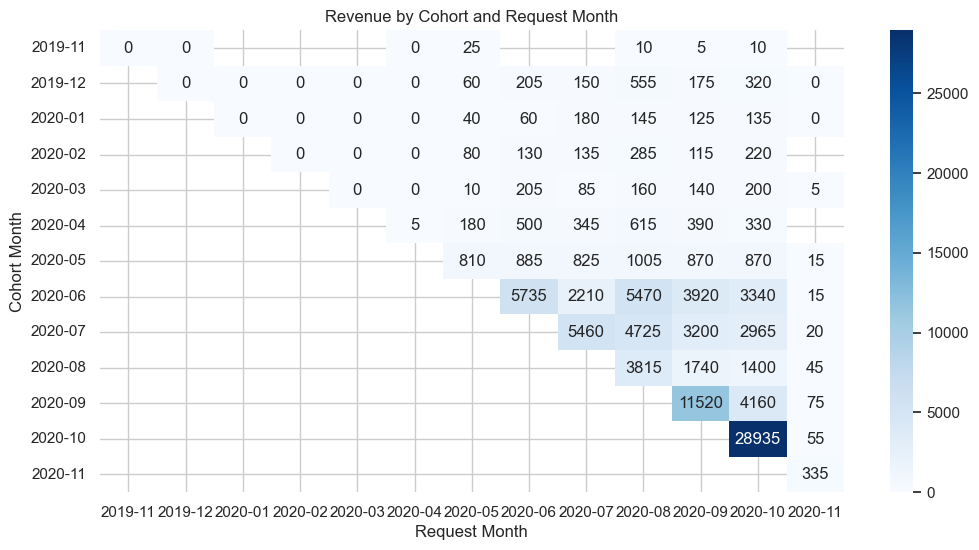

In [327]:
##3. **Revenue Generated by the Cohort:** Calculate the total revenue generated by each cohort over months to assess the financial impact of user behavior.

#VISUALIZATION
# Group and calculate total revenue (total_amount) per cohort per request month
    #groups data by: cohort (when joined)
    #request_month (when revenue happened)
revenue_by_cohort = (
    cashRequest_cp
    .groupby(["cohort", "request_month"])["total_amount"]
    .sum()
    .reset_index()
)
# Optional: pivot the data to see it as a heatmap...doesnt do anything in this context of code.
    #turns the grouped table into a matrix (rows=cohort, columns=months, values=revenue)
revenue_pivot = revenue_by_cohort.pivot(index="cohort", columns="request_month", values="total_amount")

# Plot the heatmap
    #blue=revenue...lets you see what cohorts bring the most $ over time. 
plt.figure(figsize=(12, 6))
sns.heatmap(revenue_pivot, cmap="Blues", annot=True, fmt=".0f")
plt.title("Revenue by Cohort and Request Month")
plt.ylabel("Cohort Month")
plt.xlabel("Request Month")
plt.show()





## Merging datasets

Left-join the fees dataframe to the cashRequest dataframe on `id`/`cash_request_id` to create full dataset:
(We want to retain all cash requests even in case they have no associated fees.)

In [125]:
df = cashRequest_cp.merge(fees_cp, how='left', left_on='id', right_on='cash_request_id')
print(len(cashRequest_cp))
print(len(fees_cp))
print(len(df))



23970
21057
32094


## Further EDA

### Numerical data

#### Cash Requests

In [248]:
cashRequest_cp.describe()

,id,amount,user_id,deleted_account_id
count,23970.0,23970.000000,21867.0,2104.0
mean,13910.966124,82.720818,32581.250789,9658.755228
std,7788.117214,26.528065,27618.565773,7972.743249
min,3.0,1.000000,34.0,91.0
25%,7427.25,50.000000,10804.0,3767.0
50%,14270.5,100.000000,23773.0,6121.5
75%,20607.75,100.000000,46965.0,16345.0
max,27010.0,200.000000,103719.0,30445.0


`amount` is the only numerical variable where the statistics are meaningfully interpretable, since the others are just IDs.
Cash request amounts ranged between 1€ and 200€ with the median at 100€ and a mean of just under 83€.

The histogram below illustrates this insight, with the majority of datapoints at 100€ and most of the remainder beneath that value.

The further split-up by status also shows that almost all of the small amount requests (around 25€) have been successfully reimbursed. For amounts of 50 and 100, there is a noticable proportion of cancelled requests (probably just over half for 50€ and about 1/3 for the 100€ requests).

In [132]:
fees_cp.describe()

,id,cash_request_id,total_amount
count,21057.0,21057.0,21057.000000
mean,10646.670228,16318.449162,5.000237
std,6099.136169,6656.149949,0.034457
min,1.0,1456.0,5.000000
25%,5388.0,11745.0,5.000000
50%,10654.0,17160.0,5.000000
75%,15926.0,21796.0,5.000000
max,21193.0,27010.0,10.000000


Fees ranged between 5 and 10€ with most of them at 5€ (given that the mean is almost at 5€).

C:\Users\jd.vandebijl\AppData\Local\Temp\ipykernel_32876\3009539647.py:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(fees_cp,x='status',palette='colorblind');


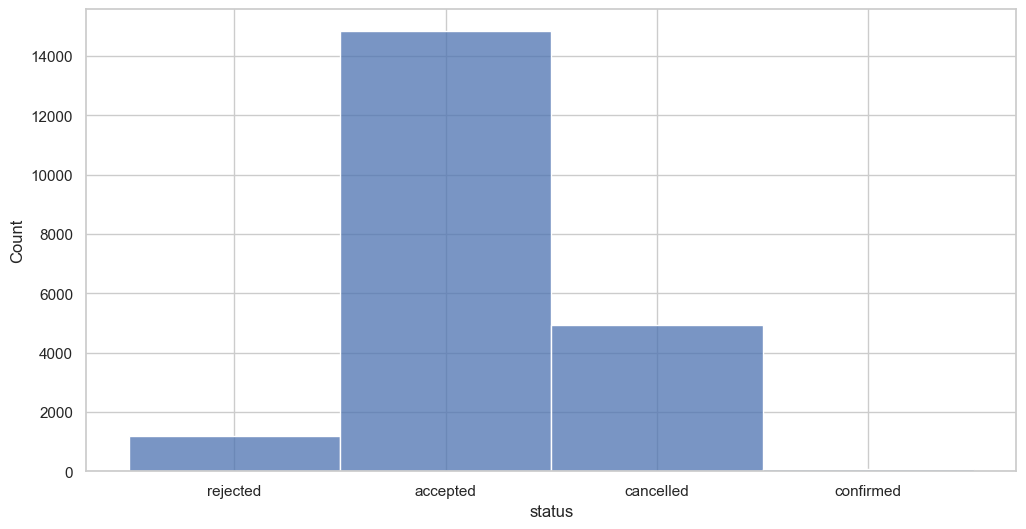

In [250]:
sns.histplot(fees_cp,x='status',palette='colorblind');

Most of the fees were successfully charged. A smaller number of fee bookings were cancelled (following the documentation mostly due to failed postpone fees, so there might be an expected correlation with type `postpone`). An even smaller number of fees had the status `rejected`, i.e. their charge had failed.

<Axes: xlabel='type', ylabel='total_amount'>

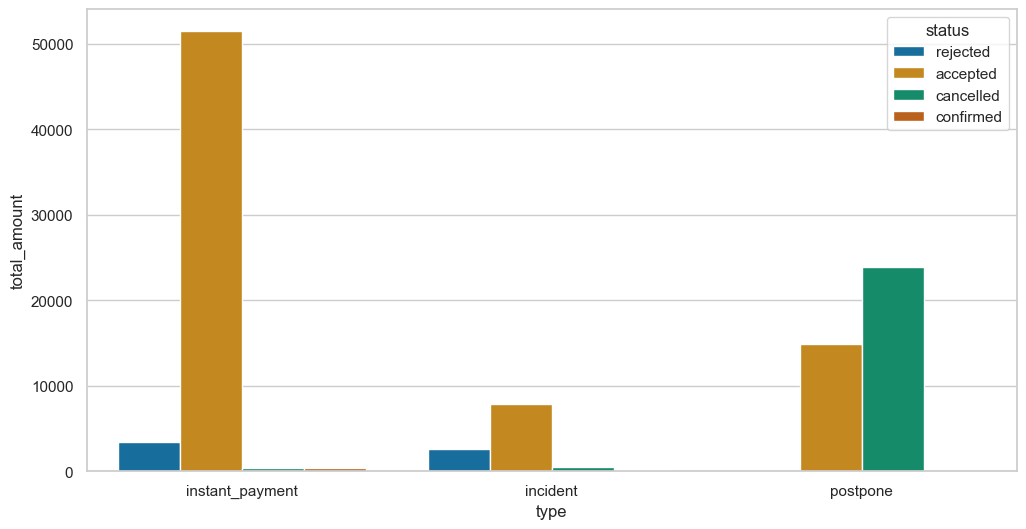

In [70]:
# total fees by type of fee
sns.barplot(fees,x='type',y='total_amount',hue='status',palette='colorblind',estimator=sum)

The major amount of fees comes from `instant_payment`s, a somewhat smaller amount from `postponement`s (of which more than half are actually cancelled) and the smalles amount comes from `incident`s

## Categorical data

In [137]:
cr_status_counts = cashRequest_cp.status.value_counts()
cr_status_counts

status
money_back               16397
rejected                  6568
direct_debit_rejected      831
active                      59
transaction_declined        48
direct_debit_sent           34
canceled                    33
Name: count, dtype: int64

In [ ]:
# Group on fees > cash_request_id and count the amount of items -> this will return us the amount of fees per cash_request_id
fee_counts = fees_cp.groupby('cash_request_id').size()

# This returns us all the cash_requests that have multiple fees 
multiple_fees = fee_counts[fee_counts > 1]

# Show them
# print(multiple_fees)
print(len(df))
print(df.info)

32094
<bound method DataFrame.info of         id_x  amount           status_x                     created_at_x  \
0          5   100.0           rejected 2019-12-10 19:05:21.596873+00:00   
1         70   100.0           rejected 2019-12-10 19:50:12.347780+00:00   
2          7   100.0           rejected 2019-12-10 19:13:35.825460+00:00   
3         10    99.0           rejected 2019-12-10 19:16:10.880172+00:00   
4       1594   100.0           rejected 2020-05-06 09:59:38.877376+00:00   
...      ...     ...                ...                              ...   
32089  22357   100.0         money_back 2020-10-20 07:58:04.006937+00:00   
32090  20256   100.0         money_back 2020-10-10 05:40:55.700422+00:00   
32091  20256   100.0         money_back 2020-10-10 05:40:55.700422+00:00   
32092  19886   100.0  direct_debit_sent 2020-10-08 14:16:52.155661+00:00   
32093  19886   100.0  direct_debit_sent 2020-10-08 14:16:52.155661+00:00   

                          updated_at_x  user_id  

In [138]:
print(df.head())

   id_x  amount  status_x                     created_at_x  \
0     5   100.0  rejected 2019-12-10 19:05:21.596873+00:00   
1    70   100.0  rejected 2019-12-10 19:50:12.347780+00:00   
2     7   100.0  rejected 2019-12-10 19:13:35.825460+00:00   
3    10    99.0  rejected 2019-12-10 19:16:10.880172+00:00   
4  1594   100.0  rejected 2020-05-06 09:59:38.877376+00:00   

                      updated_at_x  user_id                     moderated_at  \
0 2019-12-11 16:47:42.407830+00:00      804 2019-12-11 16:47:42.405646+00:00   
1 2019-12-11 14:24:22.900054+00:00      231 2019-12-11 14:24:22.897988+00:00   
2 2019-12-11 09:46:59.779773+00:00      191 2019-12-11 09:46:59.777728+00:00   
3 2019-12-18 14:26:18.136163+00:00      761 2019-12-18 14:26:18.128407+00:00   
4 2020-05-07 09:21:55.340080+00:00     7686 2020-05-07 09:21:55.320193+00:00   

   deleted_account_id               reimbursement_date  \
0                <NA> 2020-01-09 19:05:21.596363+00:00   
1                <NA> 2020-01-

In [255]:
df.columns

Index(['id_x', 'amount', 'status_x', 'created_at_x', 'updated_at_x', 'user_id',
       'moderated_at', 'deleted_account_id', 'reimbursement_date',
       'cash_request_received_date', 'money_back_date', 'transfer_type',
       'send_at', 'recovery_status', 'reco_creation', 'reco_last_update',
       'cohort_month', 'id_y', 'cash_request_id', 'type', 'status_y',
       'category', 'total_amount', 'reason', 'created_at_y', 'updated_at_y',
       'paid_at', 'from_date', 'to_date', 'charge_moment'],
      dtype='object')

<Axes: xlabel='amount', ylabel='Count'>

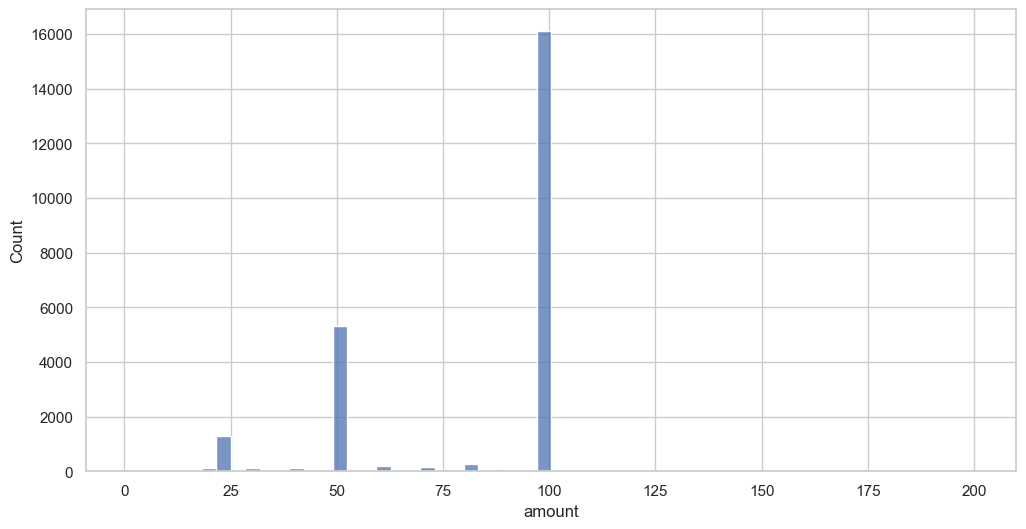

In [256]:
# histogram of amounts for cashrequests (not using the merged dataset here to avoid issues )
sns.histplot(cashRequest_cp,x="amount")

Most common cash advance requests were for 100€, followed by 50€ and some 25€ requests.

In [257]:
# plotting histogram of amount
# sns.histplot(cashRequest_cp,x="amount",y="status_x")

# Target data analysis

## Overview of cohorts

<Axes: xlabel='cohort_month'>

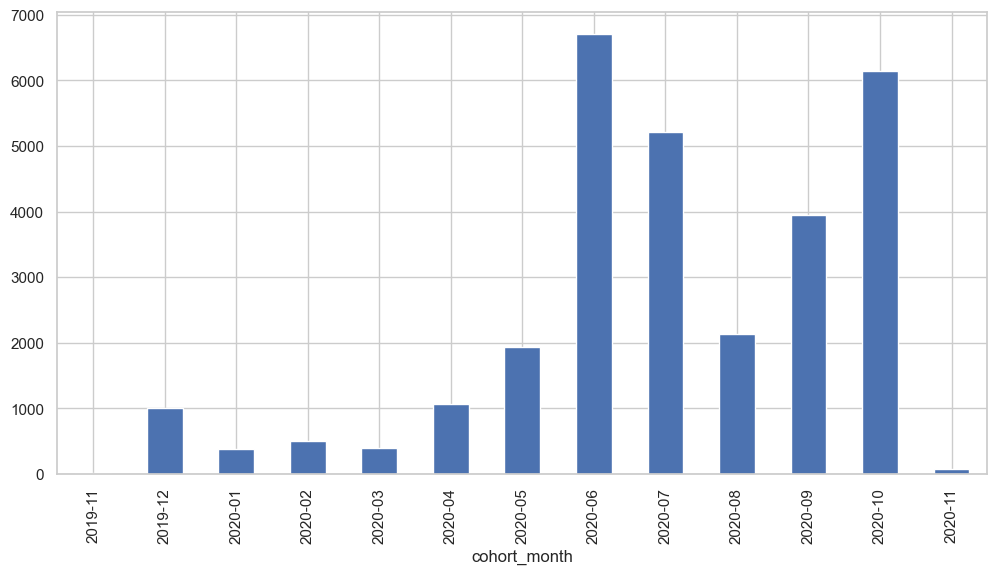

In [ ]:

# This groupes the data by the newly generated column and takes the count of cashrequest that happened in eacht period
time_plot_data = cashRequest_cp.groupby('cohort')['user_id'].count()
# print(time_plot_data)
time_plot_data.plot(kind='line')


## Task 2

C:\Users\jd.vandebijl\AppData\Local\Temp\ipykernel_32876\2991832965.py:7: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  cashRequestFees['cohort_month'] = cashRequestFees['created_at_x'].dt.to_period('M')


,id_x,cash_request_id,type,status_x,category,total_amount,reason,created_at_x,updated_at_x,paid_at,...,deleted_account_id,reimbursement_date,cash_request_received_date,money_back_date,transfer_type,send_at,recovery_status,reco_creation,reco_last_update,cohort_month
0,6537,14941,instant_payment,rejected,NaN,5.0,Instant Payment Cash Request 14941,2020-09-07 10:47:27.423150+00:00,2020-10-13 14:25:09.396112+00:00,2020-12-17 14:50:07.470110+00:00,...,<NA>,NaT,NaT,NaT,instant,2020-09-14 10:46:57.735172+00:00,pending,2020-10-11 22:52:52.274832+00:00,2020-12-20 22:40:42.556534+00:00,2020-09
1,6961,11714,incident,accepted,rejected_direct_debit,5.0,rejected direct debit,2020-09-09 20:51:17.998653+00:00,2020-10-13 14:25:15.537063+00:00,2020-12-08 17:13:10.459080+00:00,...,<NA>,NaT,2020-08-12 00:00:00+00:00,2020-12-02 03:02:41.180953+00:00,instant,2020-08-17 13:15:54.290998+00:00,completed,2020-09-09 20:51:17.992852+00:00,2020-10-10 22:58:13.306027+00:00,2020-09
2,16296,23371,instant_payment,accepted,NaN,5.0,Instant Payment Cash Request 23371,2020-10-23 10:10:58.352972+00:00,2020-10-23 10:10:58.352994+00:00,2020-11-04 19:34:37.432910+00:00,...,<NA>,NaT,2020-10-27 00:00:00+00:00,2020-11-04 19:34:37.399122+00:00,instant,2020-10-23 10:10:52.894637+00:00,NaN,NaT,NaT,2020-10
3,20775,26772,instant_payment,accepted,NaN,5.0,Instant Payment Cash Request 26772,2020-10-31 15:46:53.643958+00:00,2020-10-31 15:46:53.643982+00:00,2020-11-19 05:09:22.500223+00:00,...,<NA>,NaT,2020-11-03 00:00:00+00:00,NaT,instant,2020-10-31 15:46:46.846335+00:00,NaN,NaT,NaT,2020-10
4,11242,19350,instant_payment,accepted,NaN,5.0,Instant Payment Cash Request 19350,2020-10-06 08:20:17.170432+00:00,2020-10-13 14:25:03.267983+00:00,2020-11-02 14:45:20.355598+00:00,...,19005,NaT,2020-10-09 00:00:00+00:00,2020-11-02 14:45:20.315696+00:00,instant,2020-10-13 00:40:23.983346+00:00,completed,2020-10-24 22:43:13.278707+00:00,2020-11-02 14:45:20.333109+00:00,2020-10


incident count:


type,incident,instant_payment,postpone
cohort_month,,,
2020-05,0,0,16
2020-06,7,0,762
2020-07,241,100,1278
2020-08,476,1515,1061
2020-09,537,2539,1496
2020-10,925,6824,3017
2020-11,10,121,136



Cohort totals:


cohort_month
2020-05       16
2020-06      769
2020-07     1619
2020-08     3052
2020-09     4572
2020-10    10766
2020-11      267
Freq: M, dtype: int64


incident_rate:
type          incident  instant_payment  postpone
cohort_month                                     
2020-05       0.000000         0.000000  1.000000
2020-06       0.009103         0.000000  0.990897
2020-07       0.148857         0.061767  0.789376
2020-08       0.155963         0.496396  0.347641
2020-09       0.117454         0.555337  0.327209

columns:
Index(['Incident', 'Instant Payment', 'Postpone'], dtype='object')



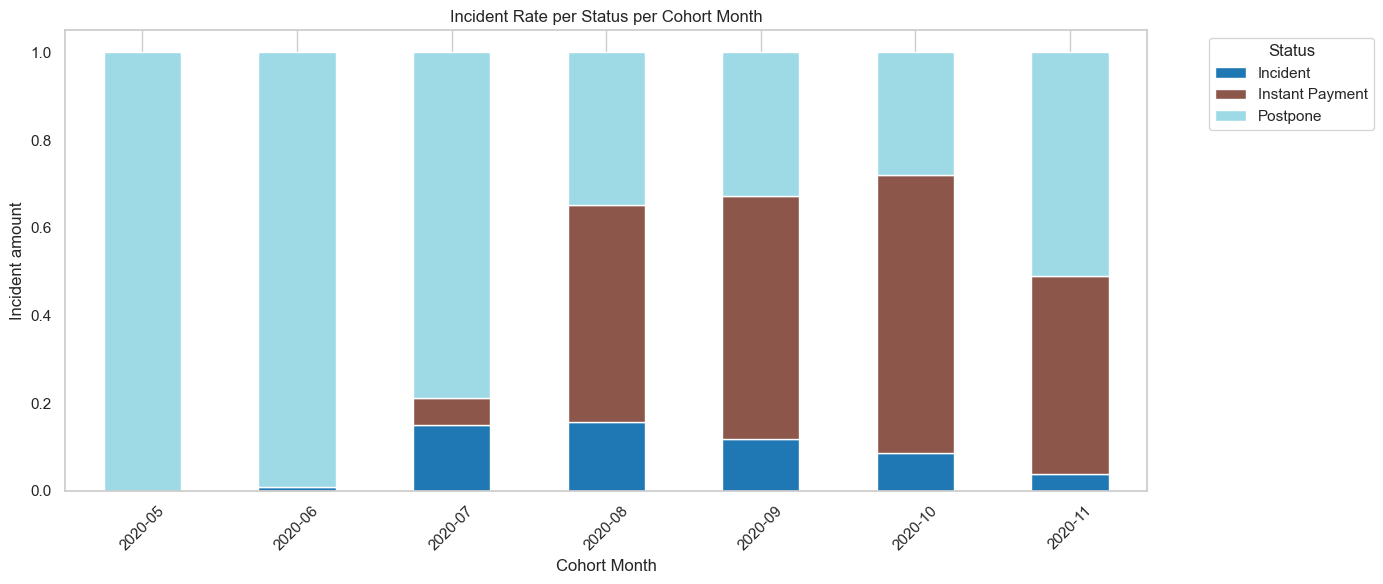

In [ ]:
# get a collection of all fees and left join the cashRequest data on it
cashRequestFees = fees.merge(cashRequest, how='left', left_on='cash_request_id', right_on='id')

# incidentFees = cashRequestFees[cashRequestFees["type"] == 'incident']

# Create a new column for the monthly cohorts
cashRequestFees['cohort'] = cashRequestFees['created_at_x'].dt.to_period('M')
display(cashRequestFees.head())

# Count number of items per (cohort, type)
incident_count = cashRequestFees.groupby(['cohort', 'type']).size().unstack(fill_value=0)
print("incident count:")
display(incident_count)
print()

# Get total rows per cohort
cohort_totals = incident_count.sum(axis=1)
print("Cohort totals:")
display(cohort_totals)
print()

# Calculate incident rate per status (per cohort)
incident_rate = incident_count.divide(cohort_totals, axis=0)
print("incident_rate:")
print(incident_rate.head())
print()

# Clean up column names: remove underscores and make it a title
incident_rate.columns = [col.replace('_', ' ').title() for col in incident_rate.columns]
print("columns:")
print(incident_rate.columns)
print()

# Plot as stacked bar chart
incident_rate.plot(
    kind='bar',
    stacked=True,
    figsize=(14, 6),
    colormap='tab20',
    title='Incident Rate per Status per Cohort Month'
)

plt.xlabel('Cohort Month')
plt.ylabel('Incident amount')
plt.legend(title='Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y')
plt.show()